<a href="https://colab.research.google.com/github/ArthAgrawal/DigiSwasth/blob/main/Kideny_Stones_Balanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_folder_path = '/content/drive/MyDrive/KidneyStones'


In [3]:
import os
class_counts = {}
for class_folder in os.listdir(dataset_folder_path):
    class_path = os.path.join(dataset_folder_path, class_folder)

    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_folder] = num_images

for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")


Class: Normal, Number of images: 828
Class: Kidney_stone, Number of images: 625


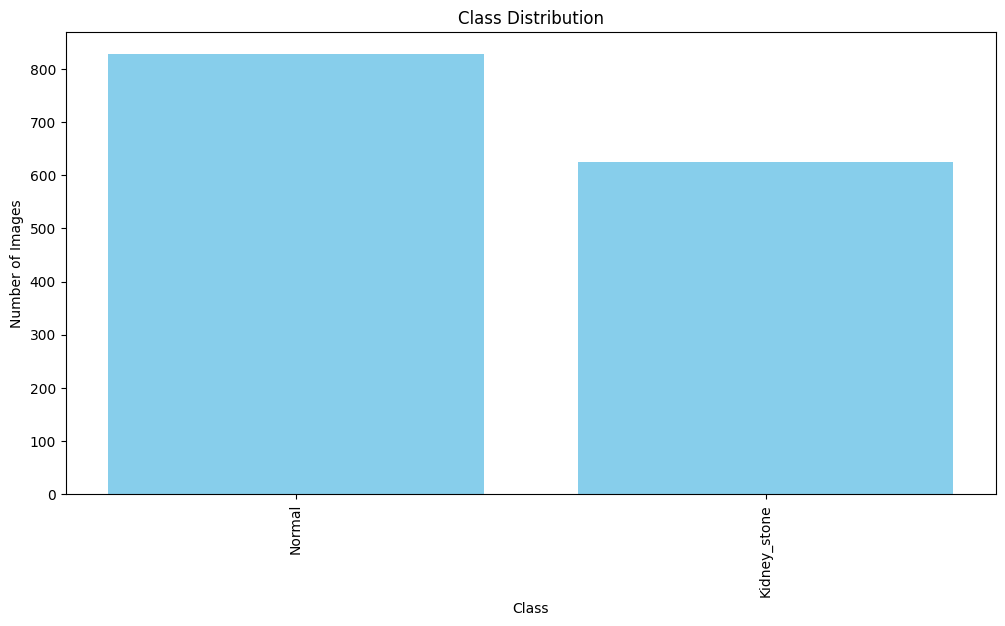

In [4]:
import matplotlib.pyplot as plt

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()


In [7]:
import albumentations as A
import cv2
import numpy as np
import os
import random

def create_augmentation_pipeline():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.ISONoise(intensity=(0.4, 0.5), color_shift=(0.07, 0.22),  p=0.4),
        A.Blur(blur_limit=(15), p=0.5),
        A.Affine(scale=(0.8, 1.2), translate_percent=(-0.1, 0.1), rotate=(-45, 45), shear=(-10, 5), p=0.2)
    ])

def augment_images_for_class(image_paths, output_dir, target_size=2000):
    augmentation_pipeline = create_augmentation_pipeline()

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    log_file_path = os.path.join(output_dir, "augmentation_log.csv")
    with open(log_file_path, 'w') as log_file:
        log_file.write("Image Filename, Augmentation Applied\n")

        num_original_images = len(image_paths)
        num_needed_augmented_images = target_size - num_original_images
        augmented_images_count = 0

        print(f"Processing class with {num_original_images} original images.")

        if num_needed_augmented_images <= 0:
            print(f"No augmentation needed. The class already has {num_original_images} images.")
            return

        print(f"Number of augmented images needed: {num_needed_augmented_images}")

        for i, image_path in enumerate(image_paths):
            if augmented_images_count >= num_needed_augmented_images:
                break

            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Image at {image_path} could not be loaded.")
                continue
            base_filename = f"original{i + 1}"
            output_image_path = os.path.join(output_dir, f"{base_filename}.png")
            cv2.imwrite(output_image_path, image)

            log_file.write(f"{base_filename}, Original\n")

        while augmented_images_count < num_needed_augmented_images:
            for i, image_path in enumerate(image_paths):
                if augmented_images_count >= num_needed_augmented_images:
                    break

                image = cv2.imread(image_path)
                if image is None:
                    print(f"Warning: Image at {image_path} could not be loaded.")
                    continue
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (256, 256))

                augmented = augmentation_pipeline(image=image)
                augmented_image = augmented['image']
                aug_image_name = f"original{i + 1}-augmented{augmented_images_count + 1}.png"
                output_aug_path = os.path.join(output_dir, aug_image_name)
                cv2.imwrite(output_aug_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

                log_file.write(f"{aug_image_name}, ")
                applied_augmentations = []
                for transform in augmentation_pipeline.transforms:
                    if random.random() < transform.p:
                        applied_augmentations.append(transform.__class__.__name__)
                log_file.write(", ".join(applied_augmentations) + "\n")

                augmented_images_count += 1

        print(f"Final count of augmented images for class: {augmented_images_count}")

def process_dataset(dataset_path, output_path, target_size=2000):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    else:
        for class_dir in os.listdir(output_path):
            class_path = os.path.join(output_path, class_dir)
            if os.path.isdir(class_path):
                for f in os.listdir(class_path):
                    os.remove(os.path.join(class_path, f))
                os.rmdir(class_path)

    class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    for class_dir in class_dirs:
        class_path = os.path.join(dataset_path, class_dir)
        image_paths = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        num_images = len(image_paths)
        if num_images > 0:
            output_dir = os.path.join(output_path, f"{class_dir}_augmented")
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            else:
                for f in os.listdir(output_dir):
                    os.remove(os.path.join(output_dir, f))

            augment_images_for_class(image_paths, output_dir, target_size)

            augmented_image_count = len([f for f in os.listdir(output_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
            print(f"Processed class '{class_dir}': {num_images} original images, augmented to {augmented_image_count} images")

dataset_path = '/content/drive/MyDrive/KidneyStones'
output_path = '/content/drive/MyDrive/KidneyStones_Augmented'

process_dataset(dataset_path, output_path)


Processing class with 828 original images.
Number of augmented images needed: 1172
Final count of augmented images for class: 1172
Processed class 'Normal': 828 original images, augmented to 2000 images
Processing class with 625 original images.
Number of augmented images needed: 1375
Final count of augmented images for class: 1375
Processed class 'Kidney_stone': 625 original images, augmented to 2000 images


Class: Normal_augmented, Number of images: 2000
Class: Kidney_stone_augmented, Number of images: 2000


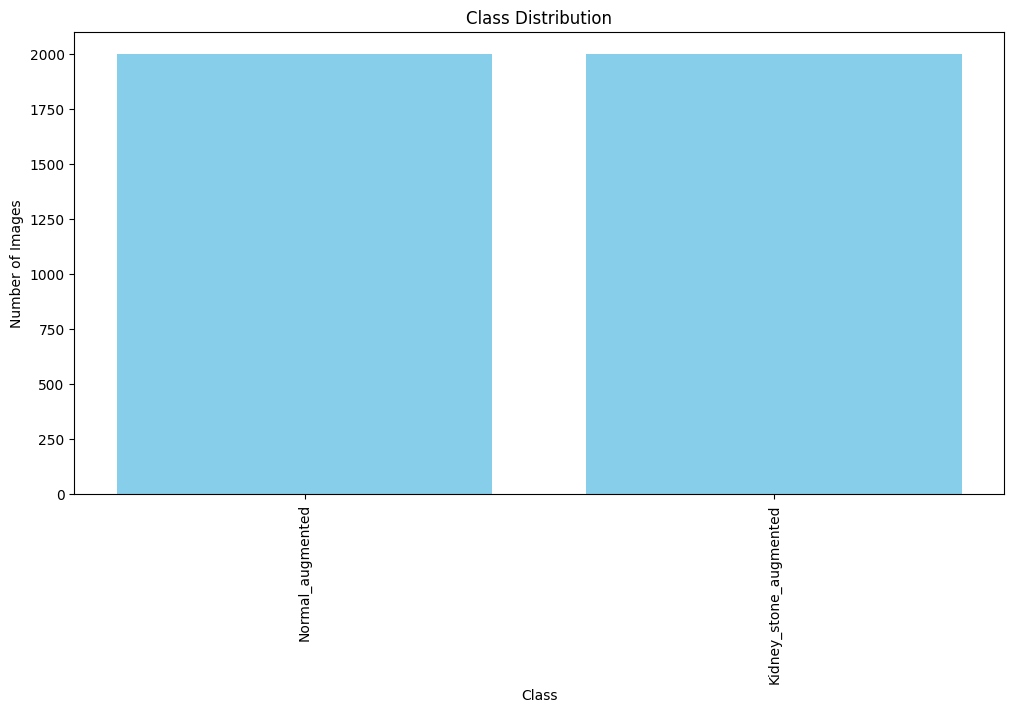

In [8]:
dataset_folder_path = '/content/drive/MyDrive/KidneyStones_Augmented'
import os
class_counts = {}
for class_folder in os.listdir(dataset_folder_path):
    class_path = os.path.join(dataset_folder_path, class_folder)

    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_folder] = num_images

for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")

import matplotlib.pyplot as plt

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

